# 1. Imports

In [1]:
import torch
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
  
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os 
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from typing import Optional, Union
import gc 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Basic settings to load in images and initializing transformations for the images for the training

In [3]:
image_path = "/content/drive/MyDrive/ML/data/archive (2)/Covid19-dataset"

In [4]:
# Get pretrained model weights and its transformations to apply them to the image data in order to train to the model later
weights = torchvision.models.ResNet18_Weights.DEFAULT
transforms = weights.transforms
print(transforms)

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224)


In [5]:
# get model infos
model = torchvision.models.resnet18(pretrained=True) 
print(model.fc)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Linear(in_features=512, out_features=1000, bias=True)


In [6]:
# get image means and stds
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [7]:
# Add custom transforms on top of needed transforms for the pretrained model
base_transforms = [
    tt.Resize((256,256), interpolation = tt.InterpolationMode.BICUBIC),
]

transforms_custom = tt.Compose([
    *base_transforms,
    tt.RandomCrop(224),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(30),
    tt.RandomVerticalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transforms = tt.Compose([
    *base_transforms,
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [8]:
# Load images into ImageFolder
train_images = ImageFolder(image_path+"/train", transform=transforms_custom)
test_images = ImageFolder(image_path + "/test", transform=test_transforms)

In [9]:
# Create dataloader
batch_size = 32
train_loader = DataLoader(train_images, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_images, batch_size=batch_size, shuffle=True, num_workers=2)

#3. Investigate data, especially label distribution and check images

In [10]:
# create label distribution of training data for further investigation
label_dist = {}
for img_class in os.listdir(image_path + "/train"):
  counter = 0 
  for img in os.listdir(image_path + "/train" + "/" +  img_class):
    counter += 1 
  label_dist[img_class] = counter

inverse_class_weights = [1/(count/sum(label_dist.values())) for count in label_dist.values() ]

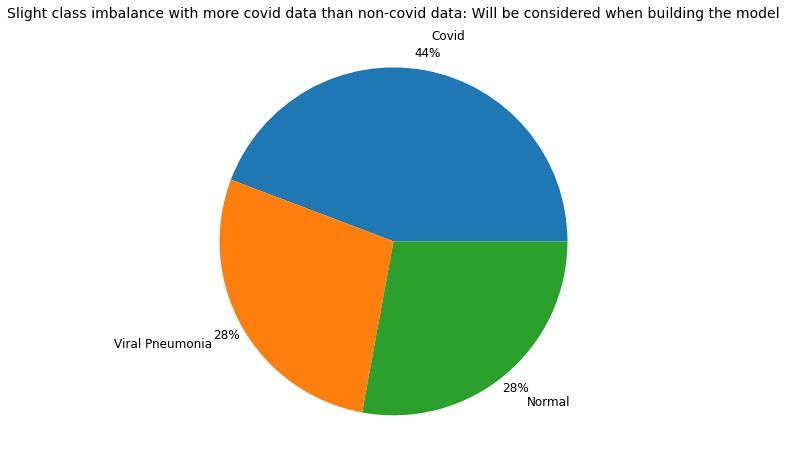

In [11]:
# plot the label distribution
fig,ax = plt.subplots(figsize=(8,8))
ax.pie(label_dist.values(), labels=label_dist.keys(), autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, textprops={"fontsize":12})
plt.title("Slight class imbalance with more covid data than non-covid data: Will be considered when building the model", fontsize=14)
plt.show()

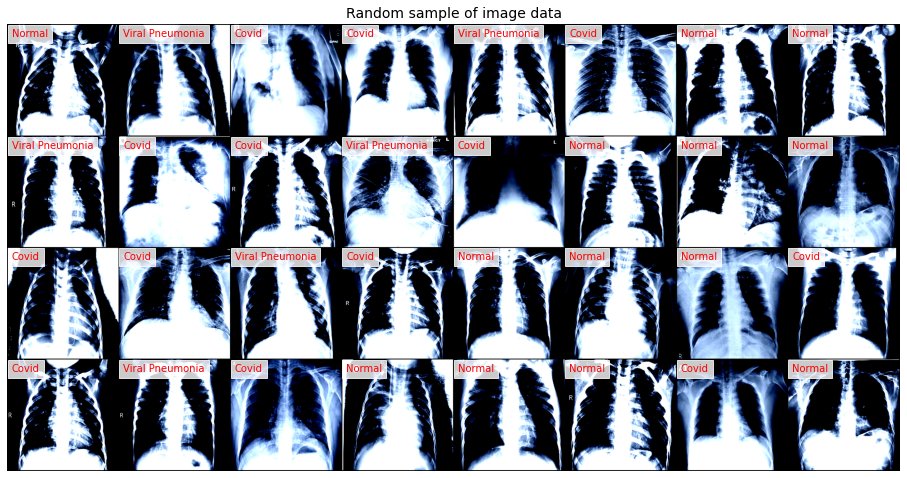

In [12]:
# Plot grid of test images, which are not augmented
for batch in test_loader:
  images,labels = batch
  grid = make_grid(images)
  grid = grid.permute(1,2,0) # permute dimensions to make it plotable for matplotlib
  break

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(grid)

ncol = 8
nrow = int(batch_size /8)

# Add labels to each grid member with a white bounding box
for col in range(ncol):
  for row in range(nrow):
    label = test_images.classes[labels[col + row]]
    t = plt.text(x=(col) * 258 + 10, y = (row) * 258 + 30, s=label , color="red", fontsize=10)
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax.axis('off')
plt.title("Random sample of image data", fontsize=14)
plt.show()

#4. Setting up the model and helper functions

In [13]:
# Build device data loader to make gpu training possible

def get_default_device():
  """
  Pick GPU if it is available otherwise CPU
  """
  if torch.cuda.is_available:
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  else:
    return data.to(device, non_blocking=True)
  
class DeviceDataLoader:
  """
  Wrap a dataloader to move data to device
  """

  def __init__(self, dl ,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """
    Yield a batch of data after moving it to device
    :return: To new device transformed dataloader
    """
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    """
    Number of batches
    """
    return len(self.dl)

In [14]:
# Build the model

class Model(nn.Module):
  def __init__(self, train_backbone_params=True):
    super().__init__()
    self.train_backbone_params = train_backbone_params

    self.model = self.init_model()
  
  
  def forward(self, xb):
    """
    Simple forward step

    :param xb: input data
    :type xb: torch.tensor
    :return: output of the model
    :rtype: torch.tensor
    """
    out = self.model(xb)
    return out
  
  def init_model(self):
    """
    Setup backbone model
    """
    #weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.resnet18(pretrained=True) 

    if self.train_backbone_params:
      for param in model.parameters():
        param.requires_grad = True
    else:
      for param in model.parameters():
        param.requires_grad = False
    
    classifier = nn.Sequential(
         nn.Linear(in_features=512, out_features=512),
         nn.ReLU(),
         nn.Dropout(0.2),
         nn.Linear(512,512),
         nn.ReLU(),
         nn.Dropout(0.2),
         nn.Linear(512,3)
    )

    model.fc = classifier
    return  model
  
  def training_step(self, batch):
    """
    Training step which computes the loss and accuracy of a train batch
    :param batch: batch of pytorch dataloader
    :type batch: torch.utils.data.DataLoader
    :return: loss, accuracy and f1_score of batch
    :rtype: tuple[torch.tensor,...]
    """
    images, labels =  batch
    out = self(images) 
    train_loss = F.cross_entropy(out,labels, weight=inverse_class_weights)
    train_acc = accuracy(out,labels)
    train_f1 = f1(out, labels)

    return train_loss, train_acc, train_f1
  
  def validation_step(self,batch):
    images, labels =  batch
    out = self(images)
    val_loss = F.cross_entropy(out,labels) # without class weights!
    val_accuracy = accuracy(out,labels)
    val_f1 = f1(out, labels)

    return {"val_loss": val_loss, "val_acc": val_accuracy, "val_f1": val_f1}

  def validation_epoch_end(self, outputs):
    """
    Returns the epoch losses after computing the mean loss and accuracy of the test batches

    :param outputs: List of test step outputs
    :type outputs: list
    :return: epoch loss and epoch accuracy
    :rtype: dict
    """
    batch_losses = [x["val_loss"] for x in outputs]
    batch_acc = [x["val_acc"] for x in outputs]
    batch_f1 = [x["val_f1"] for x in outputs]

    epoch_loss = torch.stack(batch_losses).mean().item()
    epoch_acc = torch.stack(batch_acc).mean().item()
    epoch_f1 = np.mean(batch_f1)
    return {"val_loss": epoch_loss, "val_acc": epoch_acc, "val_f1": epoch_f1}

  def evaluate(self, dl):
    self.eval()
    with torch.no_grad():
      self.eval()
      outputs = [self.validation_step(batch) for batch in dl]
      return self.validation_epoch_end(outputs)
  
  def epoch_end_val(self, epoch, results):
    """
    Prints test epoch summary after every epoch

    :param epoch: epoch number
    :type epoch: int
    :param results: results from the evaluate method
    :type results: dictionary
    :return: None
    """

    print(f"Epoch:[{epoch}]: validation loss: {results['val_loss']}, validation accuracy: {results['val_acc']},validation f1_score: {results['val_f1']}")
  
  def predict(self, xb):
    """
    :param xb: input for prediction
    :type xb: torch.tensor
    :return: prediction class
    :rtype: torch.tensor
    """
    self.eval()
    return self(xb)
    
    

In [15]:
# define helper functions and classes
def accuracy(prediction, labels):
  """
  Computes the accuracy of a prediction

  :param output: Prediction outputs
  :type output: torch.tensor
  :param labels: True labels for the output
  :type labels: torch.tensor
  :return: accuracy of the prediction
  :rtype: torch.tensor
  """
  with torch.no_grad():
    _, preds = torch.max(prediction, dim=1)
    return (torch.sum((preds == labels)) / len(preds)).clone().detach()


def f1(prediction, labels):
  """
  Computes the f1_score of a prediction

  :param output: Prediction outputs
  :type output: torch.tensor
  :param labels: True labels for the output
  :type labels: torch.tensor
  :return: f1_score of the prediction
  :rtype: torch.tensor
  """
  output = prediction.cpu() # transfer them to cpu to make coversion to numpy arrays possible 
  labels = labels.cpu()
  _, preds = torch.max(output, dim=1)
  return f1_score(labels, preds, average="macro")


# Early Stopper class for training 
class EarlyStopper:
  def __init__(self,min_delta=0, patience_steps=5):
    self.min_delta = min_delta
    self.patience_steps = patience_steps
    self.counter = 0
    self.min_validation_loss = np.inf
  
  def early_stop(self, new_val_loss):
    """
    Returns True if criterion for early stop is met
    :param new_val_loss: validation loss of epoch
    :param float:
    :return: True if early stop should be done, False otherwise
    :rtype: bool
    """
    if self.min_validation_loss > new_val_loss:
      self.min_validation_loss = new_val_loss
      self.counter = 0
    elif self.min_validation_loss + self.min_delta <= new_val_loss:
        if self.counter >= self.patience_steps:
          return True
        else:
          self.counter += 1
    else:
      return False

#5. Define training function and train the model

In [32]:
# training function
def fit(model: Union[Model, nn.Module], epochs: int, train_loader: torch.utils.data.dataloader.DataLoader, val_loader: torch.utils.data.dataloader.DataLoader,
        optimizer: torch.optim, learning_rate: float, early_stopping: bool, lr_scheduler: torch.optim.lr_scheduler, **kwargs):
  """
  Fits the model with defined optimizer, learning rate scheduler, early stopper  and laerning rate

  :param model: PyTorch model which should be trained
  :param epochs: Number of epochs
  :param train_loader: DataLoader for training data
  :param val_loader: DataLoader for validation data
  :param optimizer: PyTorch optimizer to optimize the loss
  :param learning_rate: Learning rate for the optimizer
  :param early_stopping: True if early stopping should be checked
  :param lr_scheduler: PyTorch learning rate scheduler to adjust the learning rate
  :param **kwargs: additional keyword arguments for the learning rate scheduler
  :return: history of training
  :rtype: list
  """
  
  optimizer = optimizer(model.parameters(), lr=learning_rate)

  # set up learning rate scheduler if desired
  if lr_scheduler:
    lrs = lr_scheduler(optimizer, **kwargs)
  
  # set up early stopping if desired
  if early_stopping:
    early_stopper = EarlyStopper()

  # set up list to log data of training
  history = []
  min_val_loss = float('inf')

  # set model to train mode to activate layers specific for training, such as the dropout layer
  model.train()

  for epoch in range(epochs):

    # set up list of metrics for epoch which are updated after each batch 
    train_losses = []
    train_acc = []
    train_f1 = []
    for num, batch in enumerate(train_loader):
      optimizer.zero_grad()
      print(f"New batch [{num}]")
      loss, acc, f1 = model.training_step(batch)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.detach())
      train_acc.append(acc)
      train_f1.append(f1)
  
    result = model.evaluate(val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_f1"] = np.mean(train_f1)

    history.append(result)
  
    if lr_scheduler:
      lrs.step(metrics=result["val_loss"])

    if early_stopping:
      if early_stopper.early_stop(result["val_loss"]):
        break

    model.epoch_end_val(epoch,result)
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    print(f"Train loss epoch: {result['train_loss']}")
    print(f"Train accuracy epoch: {result['train_acc']}")

    # save best model 
    if result["val_loss"] < min_val_loss:
      torch.save(model, 'best_model.pt')
      min_val_loss = result["val_loss"]
  
  return history

In [38]:
# Send models and data to gpu if possible
device = get_default_device()

model = Model()
model = to_device(model, device)

train_loader_to_device = DeviceDataLoader(train_loader, device)
test_loader_to_device = DeviceDataLoader(test_loader, device)

inverse_class_weights = to_device(torch.tensor(inverse_class_weights).clone().detach(), device)

#print summary
print(torchinfo.summary(model, input_size=(16,3,256,256)))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
Model                                         [16, 3]                   --
├─ResNet: 1-1                                 [16, 3]                   --
│    └─Conv2d: 2-1                            [16, 64, 128, 128]        9,408
│    └─BatchNorm2d: 2-2                       [16, 64, 128, 128]        128
│    └─ReLU: 2-3                              [16, 64, 128, 128]        --
│    └─MaxPool2d: 2-4                         [16, 64, 64, 64]          --
│    └─Sequential: 2-5                        [16, 64, 64, 64]          --
│    │    └─BasicBlock: 3-1                   [16, 64, 64, 64]          73,984
│    │    └─BasicBlock: 3-2                   [16, 64, 64, 64]          73,984
│    └─Sequential: 2-6                        [16, 128, 32, 32]         --
│    │    └─BasicBlock: 3-3                   [16, 128, 32, 32]         230,144
│    │    └─BasicBlock: 3-4                   [16, 128, 32, 32]         295,42

<ipython-input-38-487ce9c20c0e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverse_class_weights = to_device(torch.tensor(inverse_class_weights).clone().detach(), device)


In [39]:
# fit the model using the predefined fit function
torch.cuda.empty_cache() # empty lefover cuda cache 
history = fit(model, 100, train_loader_to_device, test_loader_to_device, torch.optim.Adam, 3e-4, False,
              torch.optim.lr_scheduler.ReduceLROnPlateau, patience=15, factor=0.05)
torch.cuda.empty_cache() # empty cuda cache after training to prevent memeory error

New batch [0]
New batch [1]
New batch [2]
New batch [3]
New batch [4]
New batch [5]
New batch [6]
New batch [7]
Epoch:[0]: validation loss: 0.9505805373191833, validation accuracy: 0.5833333730697632,validation f1_score: 0.5123666882287571
Learning rate: 0.0003
Train loss epoch: 0.918753981590271
Train accuracy epoch: 0.5603298544883728
New batch [0]
New batch [1]
New batch [2]
New batch [3]
New batch [4]
New batch [5]
New batch [6]
New batch [7]
Epoch:[1]: validation loss: 1.013500690460205, validation accuracy: 0.5833333730697632,validation f1_score: 0.45454545454545453
Learning rate: 0.0003
Train loss epoch: 1.1691118478775024
Train accuracy epoch: 0.5811631679534912
New batch [0]
New batch [1]
New batch [2]
New batch [3]
New batch [4]
New batch [5]
New batch [6]
New batch [7]
Epoch:[2]: validation loss: 0.9186140894889832, validation accuracy: 0.46875,validation f1_score: 0.3676533676533677
Learning rate: 0.0003
Train loss epoch: 1.0398414134979248
Train accuracy epoch: 0.549623847

#6. Evaluate model performance and test inference

In [44]:
#load final model 
try:
  final_model = torch.load("best_model.pt")
except RuntimeError:
  final_model = torch.load("best_model.pt", map_location=torch.device("cpu"))

In [45]:
final_model = torch.load("best_model.pt", map_location=torch.device("cpu"))

In [46]:
# stack predictions and labels from batch to compute comfusion matrix and classification report
all_preds = []
all_labels = []

for batch in test_loader:
  images, labels = batch
  out = final_model(images)
  _,preds = torch.max(out, axis=1)
  all_preds.extend(preds.tolist())
  all_labels.extend(labels.tolist())  

In [47]:
conf_matrix = confusion_matrix(all_preds, all_labels)

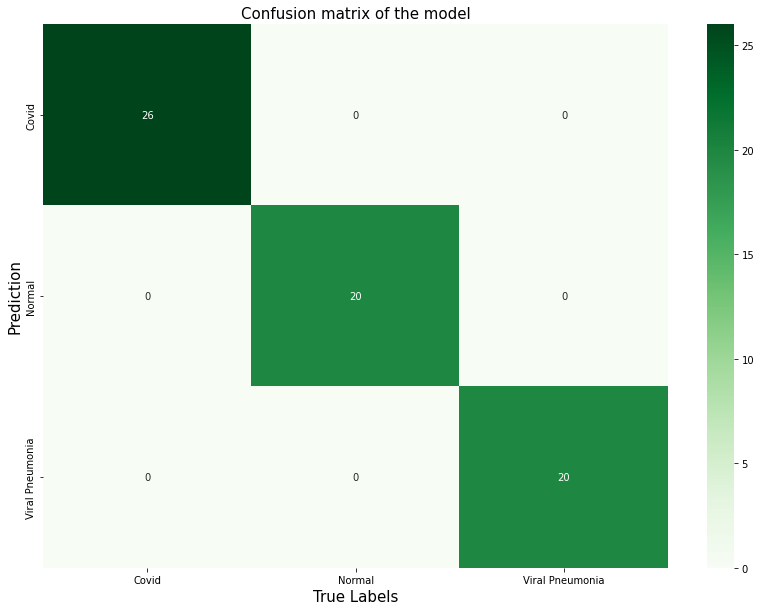

In [48]:
# Plot heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(conf_matrix,
            xticklabels=['Covid', 'Normal', 'Viral Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Viral Pneumonia'],
            annot=True,
            cmap="Greens",
            ax=ax)
ax.set_ylabel("Prediction", fontsize=15)
ax.set_xlabel("True Labels", fontsize=15)
plt.title("Confusion matrix of the model", fontsize=15)
plt.show()

In [49]:
# get classification report 
class_report = classification_report(all_preds, all_labels)
class_report_dict = classification_report(all_preds, all_labels, output_dict=True)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



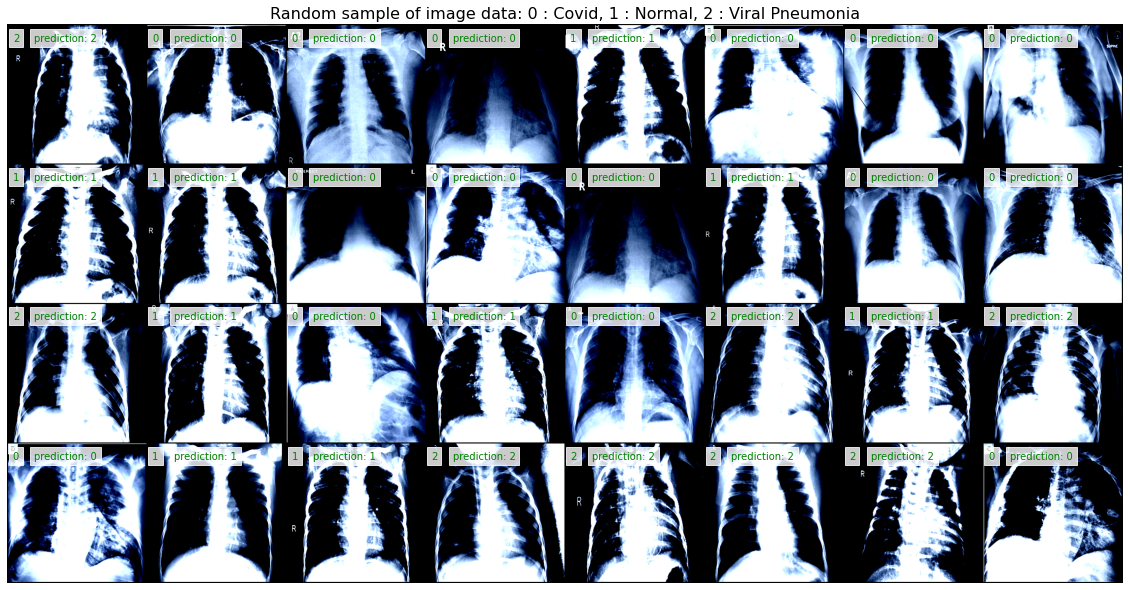

In [50]:
# Plot grid of test images, which are not augmented
for batch in test_loader:
  images,labels = batch
  grid = make_grid(images)
  grid = grid.permute(1,2,0) # permute dimensions to make it plotable for matplotlib
  break

out = final_model(images)
_,pred = torch.max(out, axis=1)

fig, ax = plt.subplots(figsize=(20,28))
ax.imshow(grid)

ncol = 8
nrow = int(batch_size /8)

# Add labels to each grid member with a white bounding box
for col in range(ncol):
  for row in range(nrow):
    label = labels[(8) * row + col]
    prediction = pred[(8) * row + col]

    # make label color red if the prediction is wrong
    if label != prediction:
      color = "red"
    else:
      color = "green"
    
    # Add bounding boxes and text to show prediction and true label for each image
    t = plt.text(x=(col) * 258 + 10, y = (row) * 258 + 30, s=label.item() , color=color, fontsize=10)
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
    t1 = plt.text(x=(col) * 258 + 50, y = (row) * 258 + 30, s=f"prediction: {prediction.item()}" , color=color, fontsize=10)
    t1.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax.axis('off')
plt.title(f"Random sample of image data: 0 : {train_images.classes[0]}, 1 : {train_images.classes[1]}, 2 : {train_images.classes[2]}"
 , fontsize=16)
plt.show()